In [1]:
# Max Mowbray, Imperial College London
# Contracted by ProAim for Supcon workshops




```
# This is a notebook to demonstrate particle swarm optimisation (PSO) to find a solution optimal control policy in a form of derivative free RL.
```

```
# Most of the PSO code was pulled from Tom Savage's Github repository: TomRSavage
```


In [2]:
# imports
import torch
import numpy as np
import scipy.integrate as scp
import copy
import numpy.random as rnd
import time
import matplotlib.pyplot as plt

## Set point tracking for a dynamic system

### State Space Model

$$x_+ = Ax + Bu$$


### Cost function 

$$\phi(x,u) = | x- {x^*} |_p$$


In [3]:
# important for Pratham (change to linear dynamic model approximation to CSTR)
class ModelIntegration:
    '''
    This files integrates the model.
    model: this is where the model should be changed
    '''

    # --- initializing model --- #
    def __init__(self, parameters):

        # Object variable definitions
        self.parameters = parameters


    # --- dynamic model definition --- #
    def model(self, t, state, u):
        # internal definitions
        params = self.parameters
        x      = state

        # parameters
        A  = params[0]; B  = params[1];

        # state update equations
        dx = A*x + B*u

        return dx[0] 

    # --- simulation --- #
    def simulation(self, controls, x0):
        '''
        u shape -> (u_{dim},steps)
        '''

        # external definitions
        self.x0 = x0

        # internal definitions
        steps = controls.shape[0]

        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))

        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.

        # simulation
        for s in range(steps):
            u    = controls[s]
            current_state = self.model(s, current_state, u)
            xt[:,s+1]     = np.array(current_state).reshape(1,1)   
            tt[s+1]       = (s+1)*1

        return xt[:,-1], tt[-1]

## Policy Functions, $\pi$


In [4]:
## Functions to be used for projection to control space

def control_proj(y, control_ub=20, control_lb=-20):
  return torch.tensor(control_ub - control_lb) * y + torch.tensor(control_lb)


def mean_std(m, mean_ub=[10,10,10], mean_lb=[0, 0, 0]):
    '''
    Problem specific restrinctions on prediction via upper and lower bound on PID gains
    '''

    mean = (torch.tensor(mean_ub) - torch.tensor(mean_lb)) * m + torch.tensor(mean_lb)


    return mean

In [5]:
class PIDController:
    """
    A Proportional-Integral-Derivative (PID) controller.

    Attributes:
        kp (float): Proportional gain.
        ki (float): Integral gain.
        kd (float): Derivative gain.
        setpoint (float): Desired target value.
        integral (float): Accumulated integral of the error.
        previous_error (float): Error from the previous step.
        output_limits (tuple): Minimum and maximum limits for the controller output.
    """

    def __init__(self, dt, setpoint=0.0, output_limits=(None, None)):
        """
        Initializes the PID controller with given parameters.

        Args:
            kp (float): Proportional gain.
            ki (float): Integral gain.
            kd (float): Derivative gain.
            setpoint (float, optional): Desired target value. Defaults to 0.0.
            output_limits (tuple, optional): Tuple of (min_output, max_output). Defaults to (None, None).
        """

        self.setpoint = setpoint

        self.integral = 0.0
        self.previous_error = 0.0
        self.dt = dt
        self.output_limits = output_limits

    def reset(self):
        """
        Resets the PID controller state.
        """
        self.integral = 0.0
        self.previous_error = 0.0

    def compute(self, PID_params, current_value):
        """
        Computes the PID control output.

        Args:
            current_value (float): The current measured value.
            dt (float): Time interval since the last update (in seconds).

        Returns:
            float: Control output.
        """
        dt = self.dt
        setpoint = self.setpoint

        kp, ki, kd = PID_params[0,0], PID_params[0,1], PID_params[0,2]


        # Calculate error
        error = setpoint - current_value

        # Proportional term
        p = kp * error

        # Integral term with anti-windup via clamping
        self.integral += error * dt
        i = ki * self.integral

        # Derivative term
        derivative = (error - self.previous_error) / dt
        d = kd * derivative

        # Compute the output
        output = p + i + d

        # Apply output limits
        min_output, max_output = self.output_limits
        if min_output is not None:
            output = max(min_output, output)
        if max_output is not None:
            output = min(max_output, output)

        # Save error for next derivative calculation
        self.previous_error = error

        return output

In [6]:
# --- Neural Networks --- #
class Net(torch.nn.Module):
  def __init__(self, **kwargs):
    super(Net, self).__init__()
    # This structure is used to define th hybrid policy model

    # Unpack the dictionary
    self.args     = kwargs
    self.dtype    = torch.float
    self.use_cuda = torch.cuda.is_available()
    self.device   = torch.device("cpu")
    self.PID_controller = PIDController(self.args['dt'])

    # defining ANN topology
    self.input_size = self.args['input_size']
    self.hs1        = self.args['hs1']
    self.hs2        = self.args['hs2']
    self.output_sz  = self.args['output_size']

    # defining activation functions
    self.tanh   = torch.nn.Tanh()

    # connect the layers
    self.hidden1 = torch.nn.RNN(self.input_size, self.hs1)
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)

    # defining output layer
    self.output = torch.nn.Linear(self.hs2, self.output_sz)
    self.reset_hn()

  def forward(self, x):
    x           = torch.tensor(x.view(1,1,-1)).float() # standardized input
    a1, self.hn = self.hidden1(x, self.hn)
    a2          = self.tanh(self.hidden2(a1))
    y           = (self.tanh(self.output(a2))+1)/2

    y = mean_std(y)

    control = self.PID_controller.compute(y.reshape(1,-1), x)
    return control.detach().numpy().squeeze().reshape(1,1)

  def reset_hn(self):
    self.hn = None
    return

class Net2(torch.nn.Module):
  def __init__(self, **kwargs):
    super(Net2, self).__init__()
    # This structure is used to define th NN only policy model
    # Unpack the dictionary
    self.args     = kwargs
    self.dtype    = torch.float
    self.use_cuda = torch.cuda.is_available()
    self.device   = torch.device("cpu")
    self.PID_controller = PIDController(self.args['dt'])

    # defining ANN topology
    self.input_size = self.args['input_size']
    self.hs1        = self.args['hs1']
    self.hs2        = self.args['hs2']
    self.output_sz  = self.args['output_size']

    # defining activation functions
    self.tanh   = torch.nn.Tanh()

    # connect the layers
    self.hidden1 = torch.nn.RNN(self.input_size, self.hs1)
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)

    # defining output layer
    self.output = torch.nn.Linear(self.hs2, self.output_sz)
    self.reset_hn()

  def forward(self, x):
    x           = torch.tensor(x.view(1,1,-1)).float() # standardized input
    a1, self.hn = self.hidden1(x, self.hn)
    a2          = self.tanh(self.hidden2(a1))
    y           = (self.tanh(self.output(a2))+1)/2

    y = control_proj(y)

    return y.detach().numpy().squeeze().reshape(1,1)

  def reset_hn(self):
    self.hn = None
    return




# **General Algorithm: PSO**
```
for each particle i = 1, ..., S do:
```
```
    Initialize the particle's position with a uniformly distributed random vector: xi ~ U(blo, bup)
    Initialize the particle's best known position to its initial position: pi ← xi
    if f(pi) < f(g) then
        update the swarm's best known position: g ← pi
    Initialize the particle's velocity: vi ~ U(-|bup-blo|, |bup-blo|)
```
```
while a termination criterion is not met do:
```
```
    for each particle i = 1, ..., S do
        for each dimension d = 1, ..., n do
            Pick random numbers: rp, rg ~ U(0,1)
            Update the particle's velocity: vi,d ← ω vi,d + φp rp (pi,d-xi,d) + φg rg (gd-xi,d)
        Update the particle's position: xi ← xi + lr vi
        if f(xi) < f(pi) then
            Update the particle's best known position: pi ← xi
            if f(pi) < f(g) then
                Update the swarm's best known position: g ← pi
```

In [7]:
#########################################################
# ------- Particle Swarm Optimisation Functions ------- #
#########################################################

# ------------------------------------------------------- #
# -------------- Method Specific functions -------------- #
# ------------------------------------------------------- #


def local_best_get(particle_pos,particle_pos_val,p):
    local_best=[0]*p #creating empty local best list
    for j in range(p):  #finding the best particle in each neighbourhood
                        #and storing it in 'local_best'
        local_vals=np.zeros(3)
        local_vals[0]=particle_pos_val[j-2]
        local_vals[1]=particle_pos_val[j-1]
        local_vals[2]=particle_pos_val[j]
        min_index=int(np.argmin(local_vals))
        local_best[j-1]=particle_pos[min_index+j-2][:]
    return np.array(local_best)




def PSUinitiation(f,bounds,p):
    '''
    INPUTS
    f       :function to be searched over
    bounds  :bounds of function in form [[x1,x2],[x3,x4],[x5,x6]...]
    p       :number of particles

    OUTPUTS
    particle_pos      :array of random particle positions
    particle_best     :array of best particle positions (same as current)
    swarm_best        :coordinates of particle with best known position
    particle_velocity :array of random particle velocity arrays
    local_best        :array of the best particle in each neighbourhood
    local_best_fitness:function value evaluated at each local best
    particle_pos_val  :fitness of each particle

    '''
    d=len(bounds) #finding number of dimensions
    particle_pos=np.zeros(p) #creating empty position array
    particle_pos=particle_pos.tolist() #converting array to list
    particle_velocity=particle_pos[:] #empty velocity array
    particle_pos_val=particle_pos[:] #empty value array
    for j in range(p): #iterating ovre the number of particles
        particle_pos[j]=[rnd.uniform(bounds[i][0],bounds[i][1])\
                    for i in range(d)] #random coordinate within bounds
        particle_pos_val[j]=f(particle_pos[j]) #calculating function value
                                            #at each particle
        particle_velocity[j]=[rnd.uniform(-abs(bounds[i][1]-bounds[i][0])\
                    ,abs(bounds[i][1]-bounds[i][0])) for i in range(d)]
                    #creating random velocity values for each dimension

    local_best=local_best_get(particle_pos,particle_pos_val,p)

    swarm_best=particle_pos[np.argmin(particle_pos_val)]#getting the lowest particle value
    particle_best=copy.deepcopy(particle_pos)#setting all particles current positions to best
    return d,np.array(particle_pos), np.array(particle_best), \
                 np.array(swarm_best), np.array(particle_velocity), np.array(local_best), \
                     np.array(particle_pos_val)

def PSUwithinbounds(bounds,particle_pos):
    '''
    DESCRIPTION:
        Checks whether a particle's position is within the bounds of the problem
        and contraints particles within bounds

    INPUTS
    bounds      :bounds of problem in form [[x1,x2],[x3,x4]...]
    particle_pos:coordinates of a particle e.g [p1,p2,p3...]


    '''
    for i in range(len(bounds)):
        if particle_pos[i]<bounds[i][0]: #if particle is less than lower bound
            particle_pos[i]=bounds[i][0]
        elif particle_pos[i]>bounds[i][1]: #if particle is more than higher bound
            particle_pos[i]=bounds[i][1]
    return


In [8]:
def particleswarm(f,bounds,p,c1,c2,vmax,tol):
    '''
    DESCRIPTION
    see https://en.wikipedia.org/wiki/Particle_swarm_optimization

    INPUTS
    f           :function to be optimized
    bounds      :bounds of each dimension in form [[x1,x2],[x3,x4]...]
    p           :number of particles
    c1          :adjustable parameter
    c2          :adjustable parameter
    vmax        :maximum particle velocity
    tol         :tolerance for exit condition

    OUTPUTS
    swarm_best  : coordinates of optimal solution, with regards to exit
                  conditions
    '''
    print('Currently placing particles and giving them random \
    velocities...')
    d,particle_pos, particle_best, swarm_best, particle_velocity, \
        local_best, pos_val \
    = PSUinitiation(f,bounds,p) #initializing various arrays
    old_swarm_best=[0]*d
    c3=c1+c2
    K=2/(abs(2-c3-np.sqrt((c3**2)-(4*c3)))) #creating velocity weighting factor
    it_count=0
    while (abs(f(old_swarm_best)-f(swarm_best))>tol) & (it_count < 300): #exit condition

        it_count+=1
        if it_count>1000: #every 1000 iterations...
                        #create 'conflict' within the swarm and
                        #give all particles random velocities
            print('Particles are too friendly! Creating conflict...')
            for j in range(p): #iterating ovre the number of particles
                particle_velocity[j]=[(rnd.uniform(-abs(bounds[i][1]-bounds[i][0])\
                    ,abs(bounds[i][1]-bounds[i][0]))) for i in range(d)]
                    #adding random velocity values for each dimension
            it_count=0 #reset iteration count

        for i in range(p): #iterates over each particle
            rp,rg=rnd.uniform(0,1,2) #creates two random numbers between 0-
            particle_velocity[i,:]+=(c1*rp*(particle_best[i,:]-particle_pos[i,:]))
            particle_velocity[i,:]+=(c2*rg*(local_best[i,:]-particle_pos[i,:]))
            particle_velocity[i,:]=particle_velocity[i,:]*K
            if particle_velocity[i].any() > vmax : #is any velocity is greater than vmax
                    particle_velocity[i,:]=vmax #set velocity to vmax
            #all of the above is regarding updating the particle's velocity
            #with regards to various parameters (local_best, p_best etc..)
            particle_pos[i,:]+=particle_velocity[i,:] #updating position

            PSUwithinbounds(bounds,particle_pos[i]) #if particle is out of bounds

            particle_fitness=f(particle_pos[i])

            if particle_fitness < pos_val[i]:
                particle_best[i,:]=particle_pos[i,:] #checking if new best
                pos_val[i]=particle_fitness
                f_swarm_best=f(swarm_best)
                if particle_fitness < f_swarm_best:
                    old_swarm_best=swarm_best[:]
                    swarm_best=copy.deepcopy(particle_best[i,:])
                    #print('current function value: ',f(swarm_best))

        local_best=local_best_get(particle_pos,pos_val,p)

    print('PSO Optimum at: ',swarm_best,'\n','Function at optimum: ',f(swarm_best), '\n', 'function evals:', it_count*p)
    return swarm_best, f(swarm_best)

In [14]:
############################
# one episode run function #
############################

class Simulation(object):
  def __init__(self, sample_size, nk, nu, nx, x0, x0_var, theta,
                    theta_var, u_min, u_max, x_mean, x_std, l2_regc, network, **kwargs):
    # --- unpacking arguments --- #
    self.sample_size = sample_size
    self.nk, self.nu, self.nx, self.x0, self.x0_var = nk, nu, nx, x0, x0_var
    self.theta, self.theta_var, self.l2_regc = theta, theta_var, l2_regc
    self.u_min, self.u_max, self.x_mean, self.x_std = u_min, u_max, x_mean, x_std
    self.policy = network(**kwargs)


  def run_episode(self, policy1, x0, model):
      '''
      This code is adapted for the optimization of a batch process, meaning a fixed final
      time, and a state as "time-to-termination"

      Single MC: Compute a single episode given a policy.
      input: Specification
      Output: Reward for each episode

      nk: number of steps, dis:, F, x0: initial state, u_min, u_max
      '''
      # --- unpacking arguments --- #
      nk, nu, nx, x0 = self.nk, self.nu, self.nx, self.x0
      u_min, u_max, x_std = self.u_min, self.u_max, self.x_std


      # ----------- Initialize episode ----------- #
      u_trajectory = np.zeros([nk, nu]) #U = np.zeros([nk, nu]) erase
      x_trajectory = np.zeros([nk, nx]) #y = np.zeros([nk, nx]) erase

      # -- initial conditions -- #
      x_k = x0.copy() # integrated_staten = x0.copy()

      # ---- Perform MC for each time interval of (nk) steps ---- #
      for ind in range(nk):

          # ----- normalizing inputs ----- #
          x_k_norm = (x_k - x_mean)/x_std
          # ----- Compute next control action ----- #
          x_k_norm_torch          = torch.tensor((x_k_norm))
          #print(policy1(x_k_norm_torch).shape )
          mean_uk                 = policy1(x_k_norm_torch)   # control prediction from PID
          #print(mean_uk, mean_uk.shape)
          u_k                     = np.reshape(mean_uk, (nu, 1))
          # ----- hard bounds on constraints ----- #
          for i_u in range(len(u_min)): # enforcing bounds on the control prediction
              if u_k[i_u]  < u_min[i_u]:
                  u_k[i_u] = u_min[i_u]
              if u_k[i_u]  > u_max[i_u]:
                  u_k[i_u] = u_max[i_u]

          # ----- compute next states from "real system" ----- #
          xt, _ = model.simulation(np.array(u_k).reshape(1,-1), x_k) # system simulation of continuous time dynamics and next observation of systems state
          x_k = xt
          # ----- storage of data ----- #
          u_trajectory[ind, :] = np.copy(np.array(u_k).reshape(1,-1))
          #print(x_k)
          x_trajectory[ind, :] = np.copy(np.array(x_k).reshape(1,-1))



      # ----- return ----- #
      return  u_trajectory, x_trajectory

  ############################
  # Sample episodes function #
  ############################

  def load_params(self, x):
    # --- unpacking arguments --- #
    policy = self.policy

    layers = [xt1.data for xt1 in policy.parameters()]
    indx_l = np.array(0)
    indx   = np.array(0)
    for i in range(len(layers)):
      try:
        dim = layers[i].data.shape[0] * layers[i].data.shape[1]
      except:
        dim = layers[i].data.shape[0]

      # transfer x value to parameters of neural network
      indx += np.array(dim)
      layers[i].data.copy_(torch.tensor(x[indx_l:indx]).reshape(layers[i].data.shape))
      indx_l = indx.copy()

    self.policy = policy

    return self.policy

  def RL_simulation(self,x, validate = False):
      '''
      Perform all the MC's for a given candidate. This means we either evaluate the candidate once
      in the case of a deterministic system and 50+ evaluations for stochastic systems.

      input: Policy, physical system, specifications
      output: expected reward, historical data
      '''
      # --- unpacking arguments --- #
      nk, nu, nx, x0, x0_var = self.nk, self.nu, self.nx, self.x0, self.x0_var
      theta, theta_var = self.theta, self.theta_var
      sample_size = self.sample_size
      # ----- internal definitions ----- #
      rewards          = [None for _ in range(sample_size)]

      # historical data
      h_xs = np.zeros([sample_size, nk+1, nx])
      h_us = np.zeros([sample_size, nk, nu])

      # load parameters of current sample
      policy1 = self.load_params(x)


      # ----- loop over a number of episodes ----- #
      for epi in range(sample_size):

          # Parametric uncertainty
          pvar_epi     = np.random.multivariate_normal(np.zeros(theta_var.shape[0]), np.diagflat(theta_var))
          theta_epi    = {indx:theta[indx]+pvar_epi[indx] for indx,key1 in enumerate(theta)}
          model        = ModelIntegration(theta_epi)
          # Random intial conditions
          x0_epi       = x0 + np.random.multivariate_normal(np.zeros(nx), np.diagflat(x0_var))

          # ----- Historical data ----- #
          h_xs[epi, 0, :]       = x0_epi
          u_trajectory, x_trajectory = \
          self.run_episode(policy1, x0_epi, model)
          h_xs[epi, 1:, :]      = x_trajectory
          h_us[epi, :, :]       = u_trajectory


      # ----- Return ----- #
      if validate:
        return  h_us, h_xs, np.sum(np.sum(np.abs(x_trajectory), axis=0), axis=0)
      else: return np.sum(np.sum(np.abs(x_trajectory), axis=0), axis=0)







### Running the problem

In [10]:
# define policy function to optimise weights of
hypparams = {'input_size': 1,
          'hs1': 10,
          'hs2': 1,
          'output_size': 3,
             'dt': 1}

hypparams2 = {'input_size': 1,
          'hs1': 10,
          'hs2': 5,
          'output_size': 1,
             'dt': 1}

Qnet = Net(**hypparams)
piNet = Net2(**hypparams2)

In [11]:
# find dimensionality of the optimisation problem
# this will not work for convolutional layers
dim_ =[]
for p in [Qnet, piNet]:
  params = list(p.parameters())
  dim = 0
  for p in params:
    try:
      dim += p.shape[0] * p.shape[1]
    except:
      dim += p.shape[0]

  dim_.append(dim)

In [46]:
import datetime
hypp = [hypparams, hypparams2]
# ---------- set random seed and timers ---------- #
torch.manual_seed(666)
now = datetime.datetime.now()
np.random.seed(seed=0)

# ---------- problem definition ---------- #
p        = {'u_m' : 1.2, 'K_N' : 0.3, 'u_d' : 0.01, 'Y_nx' : 504.49}                 # model parameter definitions
nx                 = 1
nu                 = 1
epochs             = 500
episodes           = 1
nk                 = 30
x_mean             = np.array([0])
x_std              = np.array([4.])
u_max              = np.array([20.])
u_min              = np.array([-20.])
u_mean             = (u_max + u_min)/2.
u_std              = (u_max - u_min)/2.
x0                 = np.array([10])
x0_var             = np.sqrt(x0)*1e-12
theta_var          = np.array([p[key]*0 for key in p])      # currently a deterministic system
theta              = np.array([p[key] for key in p])
l2_regc            = 1e-12

controls, states, obj = {k: {i: None for i in range(5)} for k in range(2)}, {k: {i: None for i in range(5)} for k in range(2)}, {k: {i: None for i in range(5)} for k in range(2)}

for k in range(1):

  for j, (hp, dim, network) in enumerate(zip(hypp, dim_, [Net, Net2])):

    f = Simulation(episodes, nk, nu, nx, x0, x0_var, theta,
                        theta_var, u_min, u_max, x_mean, x_std, l2_regc, network, **hp)

    dimensions=dim
    dimension_bounds=[-5,5]   # bounds are important here
    bounds=[0]*dimensions     #creating n_d dimensional bounds
    for i in range(dimensions):
        bounds[i]=dimension_bounds

    #creates bounds [[x1,x2],[x3,x4],[x5,x6]....]

    # --- metrics for pso --- #
    p=60 #shouldn't really change
    vmax=(dimension_bounds[1]-dimension_bounds[0])*0.75
    c1=2.8 #shouldn't really change
    c2=1.3 #shouldn't really change
    tol=1e-3

    # perform optimisation
    opt_params, opt_val = particleswarm(f.RL_simulation,bounds,p,c1,c2,vmax,tol)

    h_us, h_xs, objective = f.RL_simulation(opt_params, validate = True)

    controls[j][k] = h_us
    states[j][k] = h_xs
    obj[j][k] = objective


Currently placing particles and giving them random     velocities...


/tmp/ipykernel_6071/3759933874.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float() # standardized input


PSO Optimum at:  [-5.          5.         -4.4921684  -3.13370701 -5.          5.
  4.45455895  3.84881025  5.         -5.          4.5780405   5.
 -1.94704333  5.          0.76790921 -1.29088007 -5.          0.20896848
  5.          5.          5.          4.32676621 -3.78300727 -0.22561964
 -5.          4.72647827  0.46971436 -4.61263043 -5.          4.15036792
 -3.84752634 -3.32227202 -5.         -0.4875658   4.13291364  5.
  5.          5.         -1.56698178 -1.08573273  5.          4.81800159
  5.          5.          5.          5.          3.77560058  4.1169717
  5.          5.          5.          5.         -5.          5.
  1.80700183  5.          2.18965967 -5.          4.40937454 -5.
  2.88459267  4.14732105 -3.75137613  5.         -5.          5.
  5.         -3.59028346  5.          0.95573776  5.         -5.
  3.82526697  5.         -5.         -4.90476721 -5.          0.67456226
  1.33396951  5.         -5.         -4.66706646  5.          5.
 -0.01636139 -4.20476087  

/tmp/ipykernel_6071/3759933874.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float() # standardized input


PSO Optimum at:  [-4.95380038 -4.79998858 -4.67123076  0.47250812 -3.15407305 -2.42005211
 -4.99581106 -0.81334707  5.         -2.91345847  1.47461447 -1.3274407
 -2.62771137  2.31567318 -1.10503739 -3.14760351  0.91535143  4.29782546
  3.10724673 -0.02398544  3.59886969 -1.36915228 -0.74953554 -3.91944358
 -2.32408755  5.          0.74485876 -4.37440027 -0.28001351  4.17497378
 -1.53386538 -0.48570716  1.37537114  3.19745375  2.97289957 -4.9975925
 -1.9144085  -4.99879093 -2.88726011 -3.12673772 -3.22003155 -3.46547253
  2.99189603 -1.91223885 -3.17653901  2.88104468 -1.69017472 -2.47960016
 -1.03967327  2.28598646 -1.33302182  2.46745857 -3.28745361  0.29666491
 -1.46651965 -2.54869839 -2.98245259 -4.97134261 -4.9739986   2.47727346
 -2.04655236  1.61970337  2.37726148 -2.87177159  1.5723927   4.77859524
 -2.86981365  3.27665307 -2.03909553  3.02857134  1.48422112 -2.83755034
 -0.70810295  4.46695825  1.70318503 -4.15396247 -3.48776172  2.92381956
 -2.65764053 -1.77546242 -1.82934344

## Plots

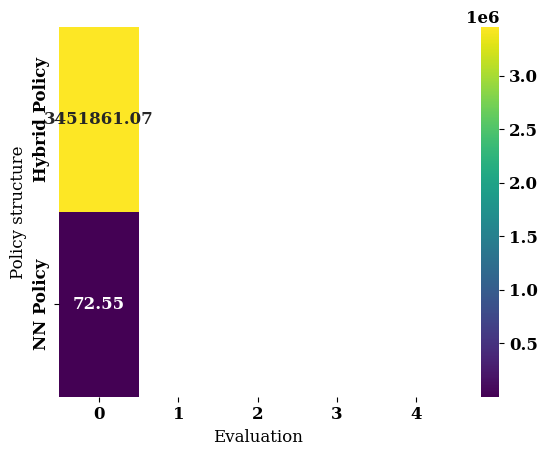

In [42]:
import seaborn as sns
import pandas as pd

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
df = pd.DataFrame(obj).T
df.index = ['Hybrid Policy', 'NN Policy']
cmap_choice = 'viridis'

sns.heatmap(df, annot=True, fmt=".2f", cmap=cmap_choice)
#plt.title('Performance Heatmap')
plt.xlabel('Evaluation')
plt.ylabel('Policy structure')
plt.savefig('Heatmap.png')
plt.show()

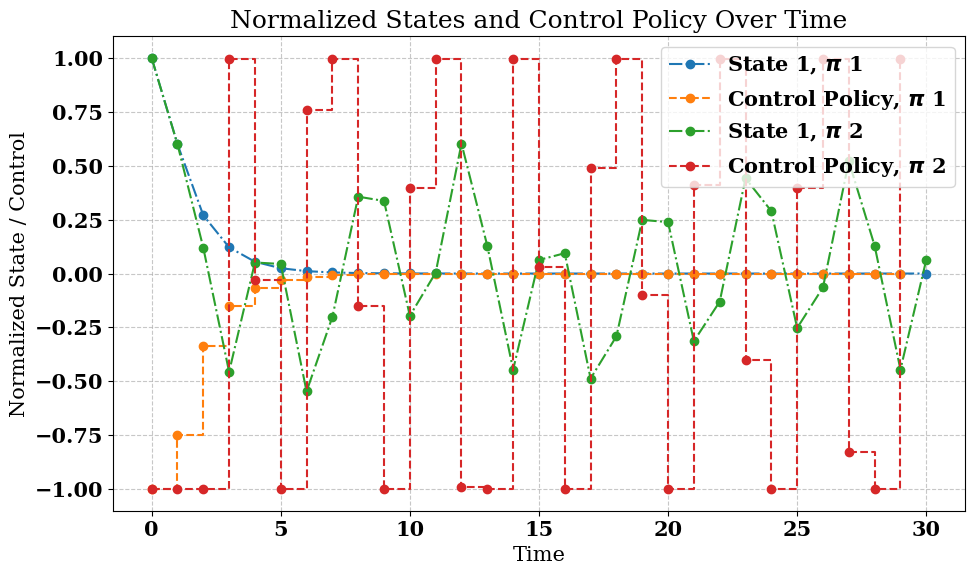

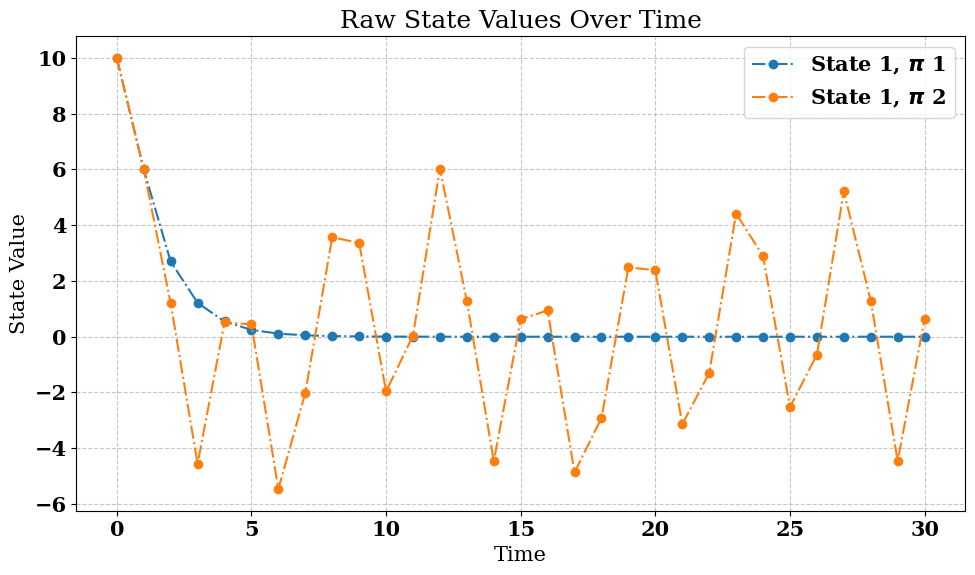

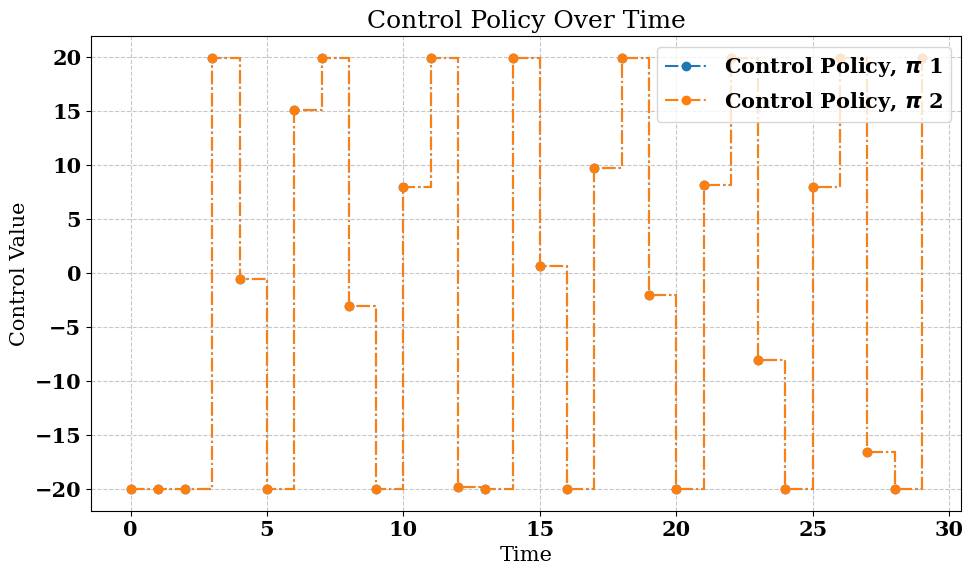

In [47]:

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)

# Plot 1: State and Control Policy Over Time (Normalized)
plt.figure(figsize=(10, 6))
for k, (h_xs, h_us) in enumerate(zip(states, controls)):
  h_xs, h_us = states[k][0], controls[k][0]
  tt = np.linspace(0, h_xs.shape[1]-1,h_xs.shape[1])
  for i in range(h_xs.shape[2]):
      plt.plot(tt, h_xs[:, :, i].squeeze() / np.max(np.abs(h_xs[:, :, i])), label=f'State {i+1}, $\pi$ {k+1}', linewidth=1.5, linestyle='-.', marker='o')
  plt.step(tt[:-1], h_us.squeeze() / np.max(np.abs(h_us.squeeze())), where='post', label=f'Control Policy, $\pi$ {k+1}', linestyle='--', marker='o')
plt.ylabel('Normalized State / Control')
plt.xlabel('Time')
plt.title('Normalized States and Control Policy Over Time')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('state_control_normal.svg')
plt.show()

# Plot 2: Raw State Values Over Time
plt.figure(figsize=(10, 6))
for k, (h_xs, h_us) in enumerate(zip(states, controls)):
  h_xs, h_us = states[k][0], controls[k][0]
  tt = np.linspace(0, h_xs.shape[1]-1,h_xs.shape[1] )
  for i in range(h_xs.shape[2]):
      plt.plot(tt, h_xs[0, :, i], label=f'State {i+1}, $\pi$ {k+1}', linewidth=1.5, linestyle='-.', marker='o')
plt.ylabel('State Value')
plt.xlabel('Time')
plt.title('Raw State Values Over Time')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('state_trajectory.svg')
plt.show()

# Plot 3: Control Policy Over Time
plt.figure(figsize=(10, 6))
for i, (h_xs, h_us) in enumerate(zip(states, controls)):
  h_xs, h_us = states[k][0], controls[k][0]
  tt = np.linspace(0, h_xs.shape[1]-1,h_xs.shape[1] )
  plt.step(tt[:-1], h_us[0, :, :].squeeze(), where='post', linewidth=1.5, linestyle='-.', marker='o', label=f'Control Policy, $\pi$ {i+1}')
plt.ylabel('Control Value')
plt.xlabel('Time')
plt.title('Control Policy Over Time')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('control_policy.svg')
plt.show()

In [45]:
controls[0]

{0: array([[[ 20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.],
         [-20.]]]),
 1: None,
 2: None,
 3: None,
 4: None}